In [1]:
from baseline.main_model import *
import pandas as pd
import numpy as np
import os
import copy  
import json
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import plotly.graph_objects as px

In [2]:
pd.options.display.float_format = '{:.4f}'.format

In [3]:
path = '/Users/Mason/Desktop/Volatility/px'
data_paths = [os.path.join(path, f) for f in os.listdir(path)]

In [4]:
file_to_read = open("russell_residual.pkl", "rb")
loaded_dictionary = pickle.load(file_to_read)  #residual from the baseline

In [5]:
file_to_read = open("russell_baseline.pkl", "rb")
loaded_result = pickle.load(file_to_read) #baseline estimation  

In [6]:
file_to_read = open("russell_size.pkl", "rb")
loaded_size = pickle.load(file_to_read) #real size saved easier to transpose 

In [7]:
def prep_data(data, date):
    df = data[data['date'] == str(date)]
    df['TIME_M']  = df['time'].apply(lambda x: '0'+x[:4]+':00' if x[1]==':' else x[:5]+':00')
    df['TIME_M']  = pd.to_timedelta(df['TIME_M'])
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['datetime'] = df['date'] + df['TIME_M']
    df.set_index('datetime', inplace=True)
    df.drop('sym_suffix', axis=1, inplace=True)
    
    df = df.between_time('9:30:00','16:00:00')
    df['pct_prx'] = df['price'].pct_change().round(decimals = 4) + 1
    df['pr_sd'] = df['pct_prx'].rolling('15T').std()
    df.fillna(pd.Timedelta(seconds=0))
    return df.between_time('9:45:00','15:59:00')

In [8]:
day_loop = pd.read_csv('time_1.csv',header=None)
day_loop.iloc[0,0]


'2021-09-01'

In [9]:
days = day_loop.values.tolist()
price_dict = [{} for i in range(len(days))]
score_dict = [{} for i in range(len(days))]

for i in tqdm(data_paths[2:3]):
    for d in range(1):
        try:
            date = day_loop.iloc[d,0]
            df = pd.read_csv(i)
            
            df = prep_data(df, date)
            ticker = df['sym_root'].unique()[0]
            if ticker in loaded_dictionary.keys():
                df = df.merge(loaded_dictionary[ticker][['time', 'residual', 'size','est']],
                                how='inner', on = 'time')
                
                reg = smf.ols(formula = "residual ~ pr_sd",data = df).fit()
                df['vol_est'] = df['est'] + reg.params[1] * df['pr_sd'].values + reg.params[0]
                abs_val = np.abs(df['vol_est'] - df['size'])/ df['size']
                price_dict[d][ticker] = df['vol_est']
                score_dict[d][ticker] = np.sum(abs_val)/len(abs_val)
        except:
            pass


100%|██████████| 1/1 [00:00<00:00, 16.49it/s]


In [10]:
score_dict

[{'SILK': 20.513318300904885},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {}]

# Metrics Comparison - PVM vs Baseline

In [11]:
day_mean_pvm = []
for i in range(len(score_dict)):
    if len(score_dict[i].values()) ==0:
        day_mean_pvm.append(0)
    else:
        day_mean_pvm.append(sum(score_dict[i].values())/len(score_dict[i].values()))
day_mean_pvm

[20.513318300904885,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [12]:
pd.DataFrame({'date':days,'day_mean_pvm':day_mean_pvm}).to_csv('day_mean_pvm.csv',index=False)

In [13]:
f = open("russell_PVM_metrics.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(score_dict,f)

# close file
f.close()

In [14]:
# read the metrics file for baseline
file_to_read = open("russell_base_metrics.pkl", "rb")
baseline = pickle.load(file_to_read)

In [15]:
final_dict = {key:(score_dict[key], baseline[key]) for key in score_dict}

TypeError: list indices must be integers or slices, not dict

In [ ]:
final = pd.DataFrame.from_dict(final_dict).transpose()
final.reset_index(inplace=True)
final.rename(columns={'index':'stock',0: "pvm", 1: "baseline"}, inplace=True)

In [ ]:
final.to_csv('final_plotly.csv')

In [ ]:
final = pd.read_csv('final_plotly.csv')

In [ ]:
final

,Unnamed: 0,stock,pvm,baseline
0,0,LEN,1.4900,1.7689
1,1,CARA,17.5117,14.7425
2,2,SILK,35.5672,38.4066
3,3,NATH,7.0856,1.9993
4,4,APPF,28.0369,24.3749
...,...,...,...,...
101,101,ENSG,19.7569,38.9798
102,102,MOV,46.2024,10.9110
103,103,BLDR,1.0443,1.0613
104,104,OLN,6.2703,16.5005


In [ ]:
len(np.where((final['pvm'] < final['baseline']))[0])

48

In [ ]:
sum(final['pvm'])/final.shape[0]

23.60164620514204

In [ ]:
sum(final['baseline'])/final.shape[0]

22.813447509569436

In [ ]:
sum(final[final['stock'] !='GCBC']['pvm'])/116 #if i remove the GCBC 

21.567021532284965

In [ ]:
final.sort_values(by=['pvm']).head(25)

,Unnamed: 0,stock,pvm,baseline
67,67,PEP,0.4631,0.4648
31,31,APA,0.5874,0.6768
90,90,MCHP,0.6696,0.6083
59,59,MRO,0.6955,0.5490
46,46,NFLX,0.7405,1.1784
85,85,GME,0.9393,0.8500
103,103,BLDR,1.0443,1.0613
50,50,APH,1.0531,1.0661
38,38,DUK,1.1429,0.9580
12,12,PXD,1.2563,0.7980


In [ ]:
fig = px.Figure()
fig = px.Figure(data=[px.Bar(
    name = 'Price Volatility Model',
    x = final['stock'],
    y = final['pvm']
   ),
                       px.Bar(
    name = 'Baseline',
    x = final['stock'],
    y = final['baseline']
   )
])
fig.update_xaxes(title_text="Russell 1000/2000")
fig.update_yaxes(title_text="Metrics Values")
fig.show()               


In [ ]:
import seaborn as sns

In [ ]:
df_dict = {}

In [ ]:
for i in tqdm(data_paths[19+58+8:]):
    date = '2021-11-23'
    df = pd.read_csv(i)
    df = prep_data(df, date)
    ticker = df['sym_root'].unique()[0]
    if ticker in loaded_dictionary.keys():
        df = df.merge(loaded_dictionary[ticker][['time', 'residual', 'size','est']],
                         how='inner', on = 'time')
        df_dict[ticker] = df

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 24.24it/s]


[Text(0.5, 1.0, 'Price Volatility versus Residual Intraday Volume - PEP')]

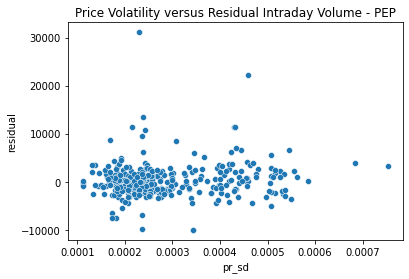

In [ ]:
sns.scatterplot(x='pr_sd', y='residual', data=df_dict['PEP']).set(title='Price Volatility versus Residual Intraday Volume - PEP')

[Text(0.5, 1.0, 'Price Volatility versus Residual Intraday Volume - APA')]

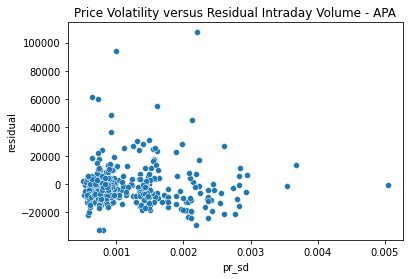

In [ ]:
sns.scatterplot(x='pr_sd', y='residual', data=df_dict['APA']).set(title='Price Volatility versus Residual Intraday Volume - APA')

[Text(0.5, 1.0, 'Price Volatility versus Residual Intraday Volume - NFLX')]

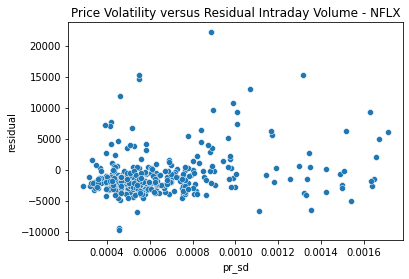

In [ ]:
sns.scatterplot(x='pr_sd', y='residual', data=df_dict['NFLX']).set(title='Price Volatility versus Residual Intraday Volume - NFLX')

[Text(0.5, 1.0, 'Price Volatility versus Residual Intraday Volume - AXGN')]

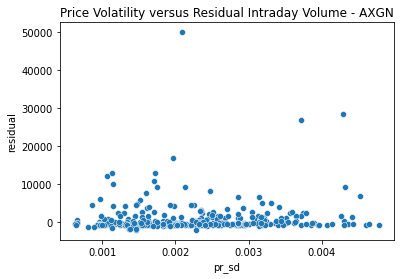

In [ ]:
sns.scatterplot(x='pr_sd', y='residual', data=df_dict['AXGN']).set(title='Price Volatility versus Residual Intraday Volume - AXGN')

[Text(0.5, 1.0, 'Price Volatility versus Residual Intraday Volume - MOV')]

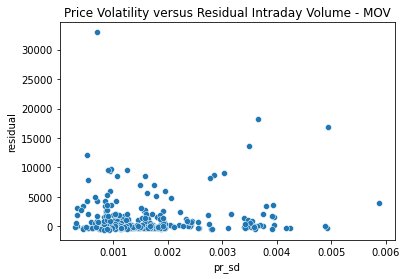

In [ ]:
sns.scatterplot(x='pr_sd', y='residual', data=df_dict['MOV']).set(title='Price Volatility versus Residual Intraday Volume - MOV')

[Text(0.5, 1.0, 'Price Volatility versus Residual Intraday Volume - BSGM')]

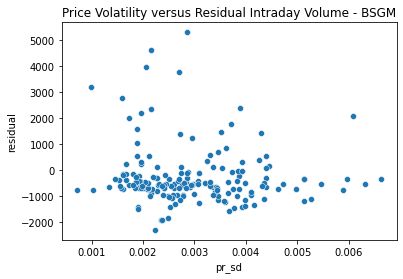

In [ ]:
sns.scatterplot(x='pr_sd', y='residual', data=df_dict['BSGM']).set(title='Price Volatility versus Residual Intraday Volume - BSGM')

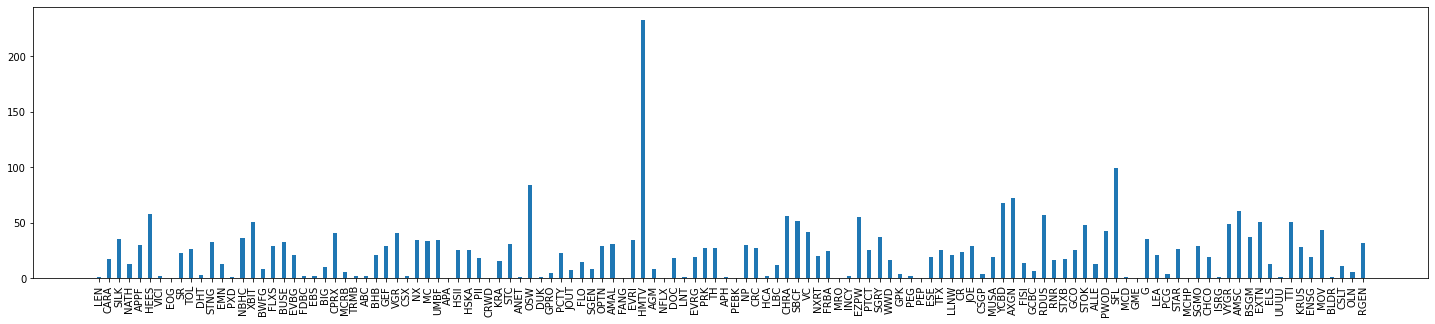

In [ ]:
#only the PVM model
name = list(score_dict.keys())
score = list(score_dict.values())
fig = plt.figure(figsize =(25, 5))
plt.bar(name, score,
        width = 0.4)
plt.xticks(rotation = 90)
plt.show()

# Error Analysis

In [ ]:
GCBC =pd.read_csv('/Users/Mason/Downloads/Volatility/px/Px_EZPW.csv')

In [ ]:
GCBC = GCBC[GCBC['date'] == '2021-10-04']

In [ ]:
GCBC['time'].unique()

array(['09:30:00', '09:31:00', '09:33:00', '09:34:00', '09:35:00',
       '09:36:00', '09:37:00', '09:38:00', '09:40:00', '09:42:00',
       '09:43:00', '09:45:00', '09:46:00', '09:47:00', '09:48:00',
       '09:49:00', '09:50:00', '09:51:00', '09:52:00', '09:55:00',
       '09:56:00', '09:57:00', '09:58:00', '10:01:00', '10:02:00',
       '10:03:00', '10:04:00', '10:05:00', '10:06:00', '10:07:00',
       '10:08:00', '10:09:00', '10:10:00', '10:11:00', '10:12:00',
       '10:14:00', '10:15:00', '10:16:00', '10:17:00', '10:18:00',
       '10:19:00', '10:20:00', '10:21:00', '10:22:00', '10:23:00',
       '10:24:00', '10:26:00', '10:29:00', '10:30:00', '10:31:00',
       '10:32:00', '10:33:00', '10:34:00', '10:35:00', '10:36:00',
       '10:37:00', '10:38:00', '10:39:00', '10:40:00', '10:41:00',
       '10:42:00', '10:43:00', '10:44:00', '10:45:00', '10:46:00',
       '10:47:00', '10:48:00', '10:49:00', '10:50:00', '10:51:00',
       '10:52:00', '10:53:00', '10:54:00', '10:55:00', '10:56:

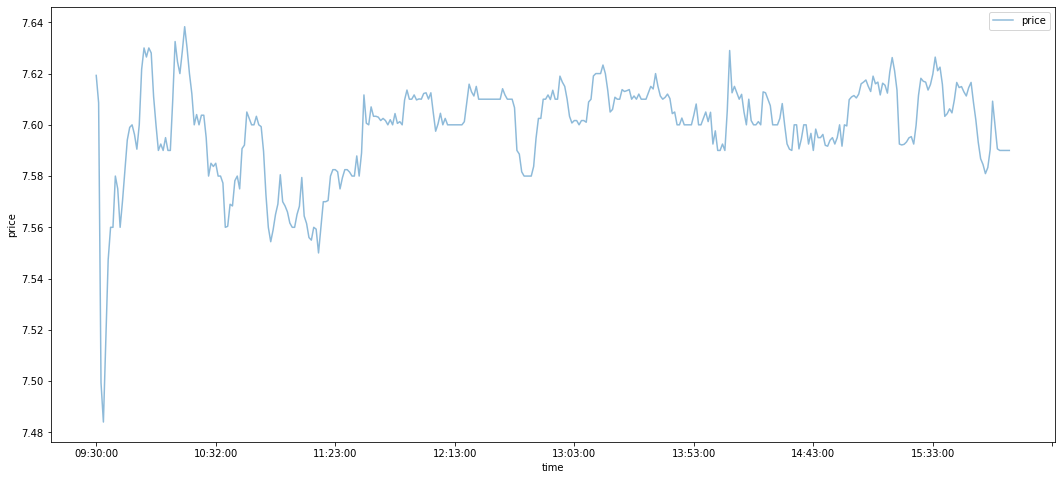

In [ ]:
fig, axs = plt.subplots(figsize=(18, 8))
GCBC.plot.line(x="time", y="price", alpha=0.5, ax=axs)
axs.set_ylabel("price")
axs.set_xlabel('time')
fig.show()